# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузим и изучим данные

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

from matplotlib import pyplot as plt
import seaborn as sb

import math
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb

#from tqdm import tqdm

In [2]:
STATE = RandomState(12345)

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
display(data.head(10))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Перед нами набор данных, включающий в себя 14 признаков и 1 целевой признак.
Данные имеют пропуски и аномалии, среди признаков могут встречаться неинформативные.
Изучим данные более подробно.

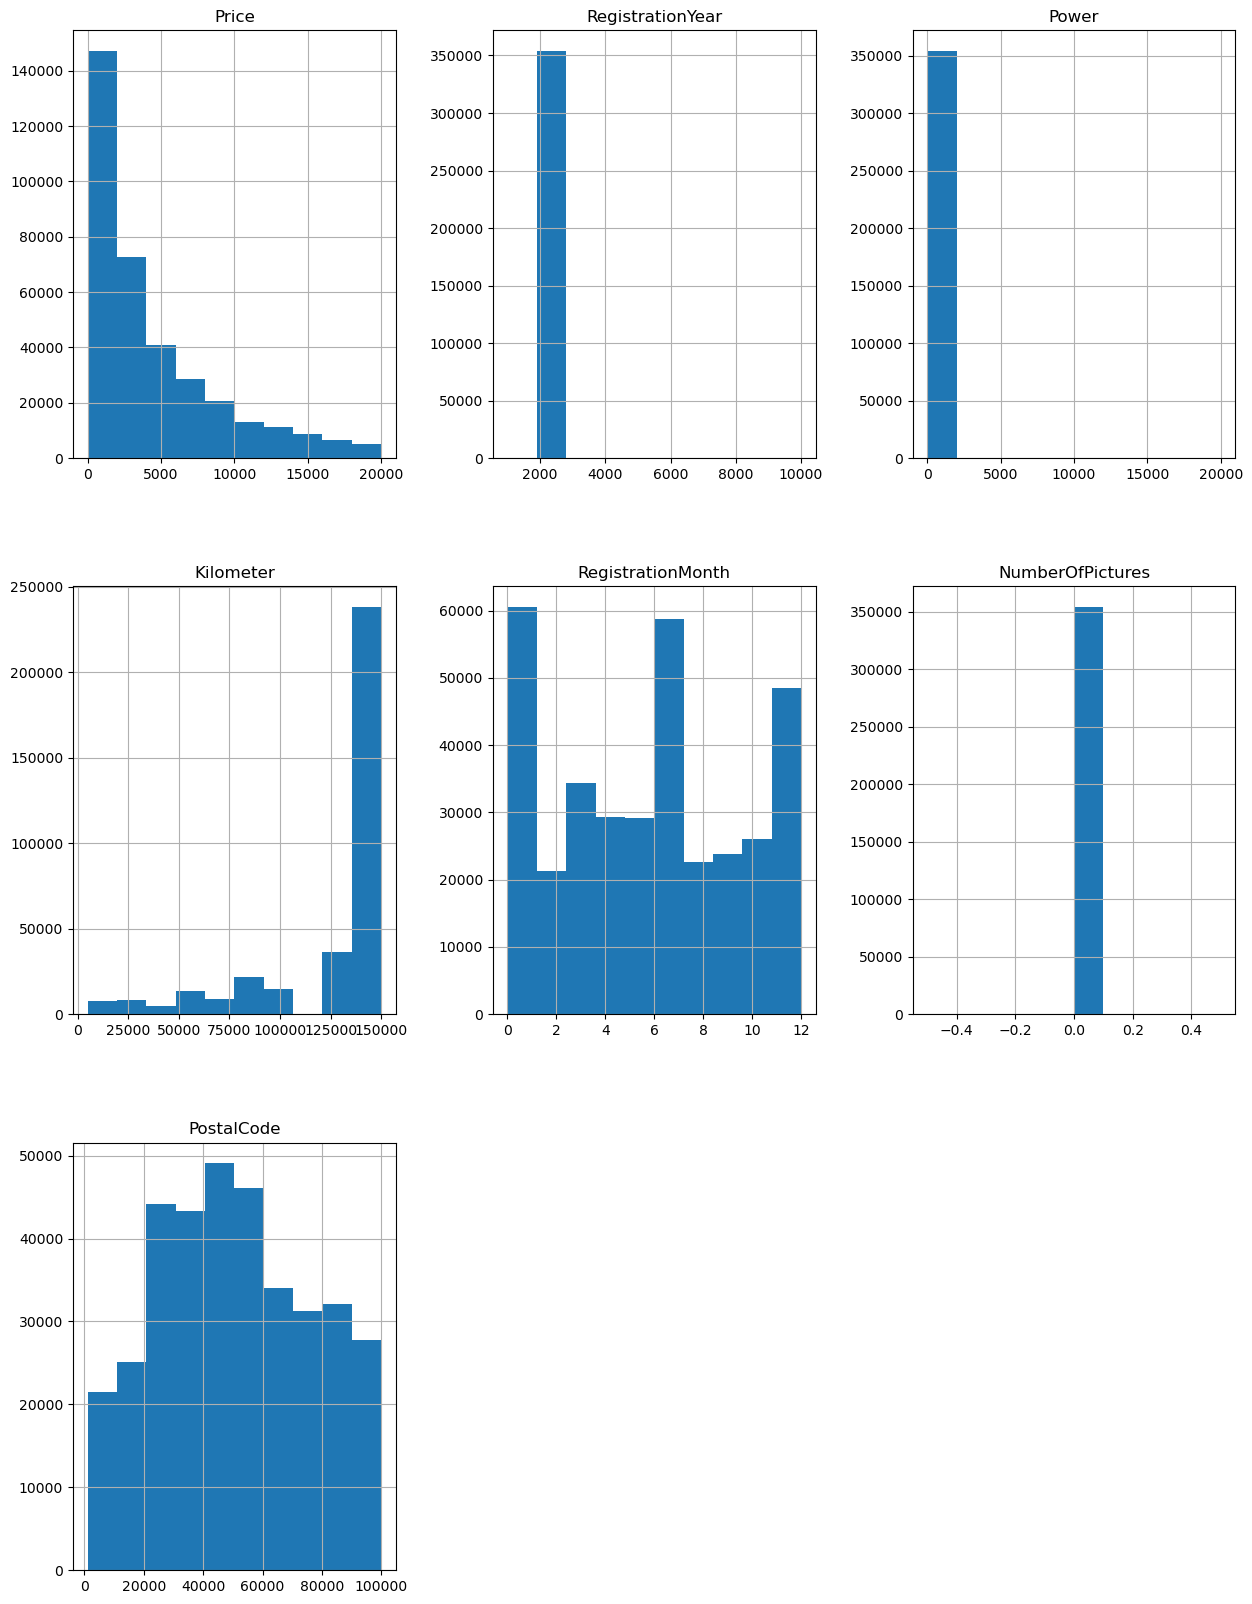

In [7]:
data.hist(figsize=(15, 20))
plt.show()

### Заполнение пропусков

Изучим и обработаем пропуски. Посчитаем количество пропусков по столбцам, отсортируем их по убыванию и оценим их процентное отношение к общему количеству данных в каждом столбце.

In [8]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

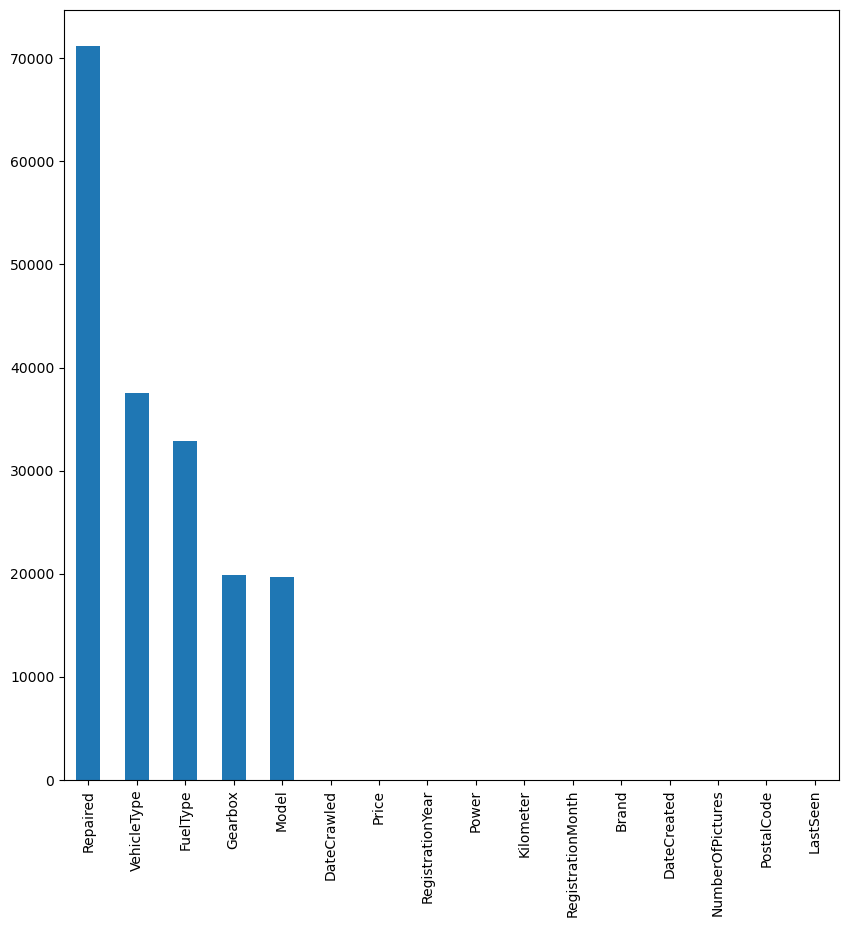

In [9]:
data.isna().sum().sort_values(ascending=False).plot(kind='bar', figsize=(10, 10))
plt.show()

In [10]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


Перед дальнейшей работой приведем названия столбцов к нижнему и змеиному регистрам для удобства.

In [11]:
data.columns = data.columns.str.lower()

In [12]:
display(data.head())

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [13]:
data = data.rename(columns={'datecrawled':'date_crawled', 'vehicletype':'vehicle_type', 'registrationyear':'registration_year', 
                            'gearbox':'gear_box', 'registrationmonth':'registration_month', 'fueltype':'fuel_type', 
                            'datecreated':'date_created', 'numberofpictures':'number_of_pictures', 'postalcode':'postal_code',
                           'lastseen':'last_seen'})

In [14]:
print(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gear_box', 'power', 'model', 'kilometer', 'registration_month',
       'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


Самое большое количество пропусков в столбце *repaired*, пропуски представлены в таком количестве, что не подлежат удалению. Восстановить данные с большой точностью не представляется возможным, поэтому выберем для заполнения значение-заглушку.

In [15]:
data['repaired'].value_counts()

no     247161
yes     36054
Name: repaired, dtype: int64

In [16]:
data['repaired'] = data['repaired'].fillna('unknown')

In [17]:
data['repaired'].value_counts()

no         247161
unknown     71154
yes         36054
Name: repaired, dtype: int64

Аналогично для столбца с типом кузова.

In [18]:
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [19]:
data['vehicle_type'] = data['vehicle_type'].fillna('unknown')

Посмотрим на уникальные значения типов топлива, поскольку здесь пропусков тоже относительно большое количество, так же установим заглушку.

In [20]:
data['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

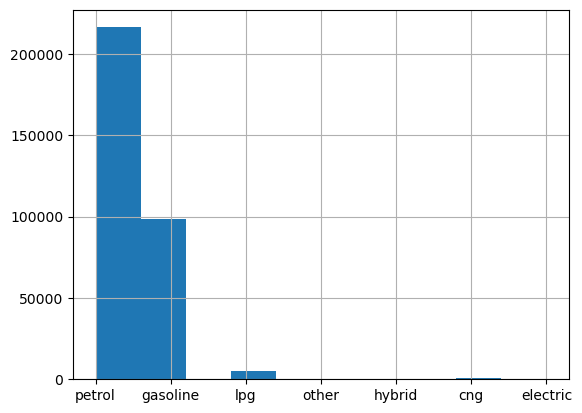

In [21]:
data['fuel_type'].hist()
plt.show()

In [22]:
data['fuel_type'] = data['fuel_type'].fillna('unknown')

Удалим пропуски в столбцах с названием модели и типом коробки передач, так как их небольшое количество, а данные не подлежат адекватному восстановлению.

In [23]:
data = data.dropna(subset=['model', 'gear_box'])

Посмотрим на результат заполнения пропусков.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318962 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        318962 non-null  object
 1   price               318962 non-null  int64 
 2   vehicle_type        318962 non-null  object
 3   registration_year   318962 non-null  int64 
 4   gear_box            318962 non-null  object
 5   power               318962 non-null  int64 
 6   model               318962 non-null  object
 7   kilometer           318962 non-null  int64 
 8   registration_month  318962 non-null  int64 
 9   fuel_type           318962 non-null  object
 10  brand               318962 non-null  object
 11  repaired            318962 non-null  object
 12  date_created        318962 non-null  object
 13  number_of_pictures  318962 non-null  int64 
 14  postal_code         318962 non-null  int64 
 15  last_seen           318962 non-null  object
dtypes:

In [25]:
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gear_box              0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Поиск аномалий

Для поиска аномалий воспользуемся описанием столбцов. Далее построим графики типа "ящик с усами", чтобы математически определить пороги аномальных значений.

In [26]:
data['price'].describe()

count    318962.000000
mean       4608.877478
std        4564.222124
min           0.000000
25%        1200.000000
50%        2900.000000
75%        6700.000000
max       20000.000000
Name: price, dtype: float64

In [27]:
data['kilometer'].describe()

count    318962.000000
mean     128844.517529
std       36620.996639
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [28]:
data['registration_year'].describe()

count    318962.000000
mean       2003.427004
std          30.517271
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9000.000000
Name: registration_year, dtype: float64

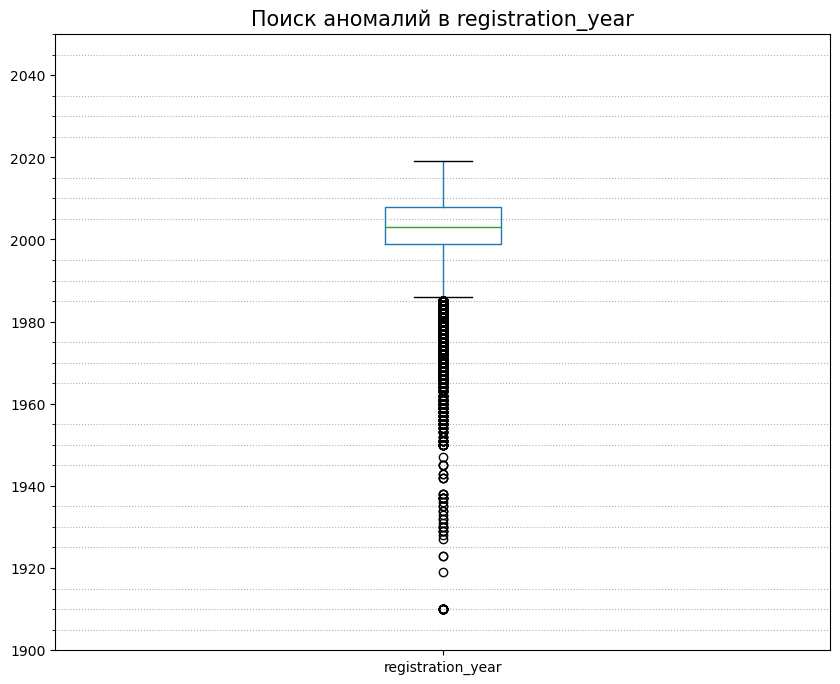

In [29]:
plt.figure(figsize=(10, 8))
data.boxplot(column='registration_year')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.title('Поиск аномалий в registration_year', fontsize=15)
plt.ylim(1900, 2050)
plt.show()

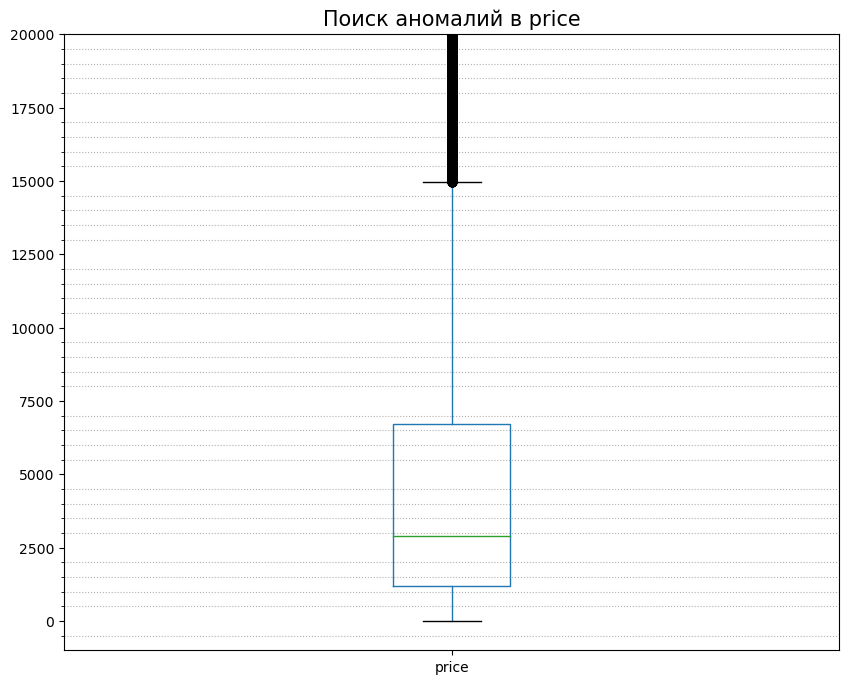

In [30]:
plt.figure(figsize=(10, 8))
data.boxplot(column='price')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.title('Поиск аномалий в price', fontsize=15)
plt.ylim(-1000, 20000)
plt.show()

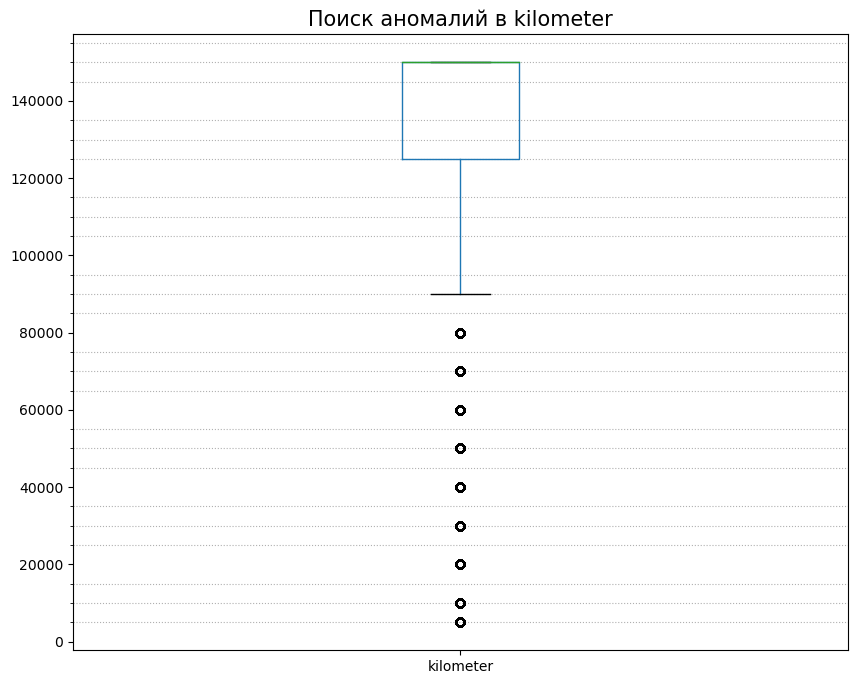

In [31]:
plt.figure(figsize=(10, 8))
data.boxplot(column='kilometer')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.title('Поиск аномалий в kilometer', fontsize=15)

plt.show()

In [32]:
data['power'].describe()

count    318962.000000
mean        114.965783
std         185.626567
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

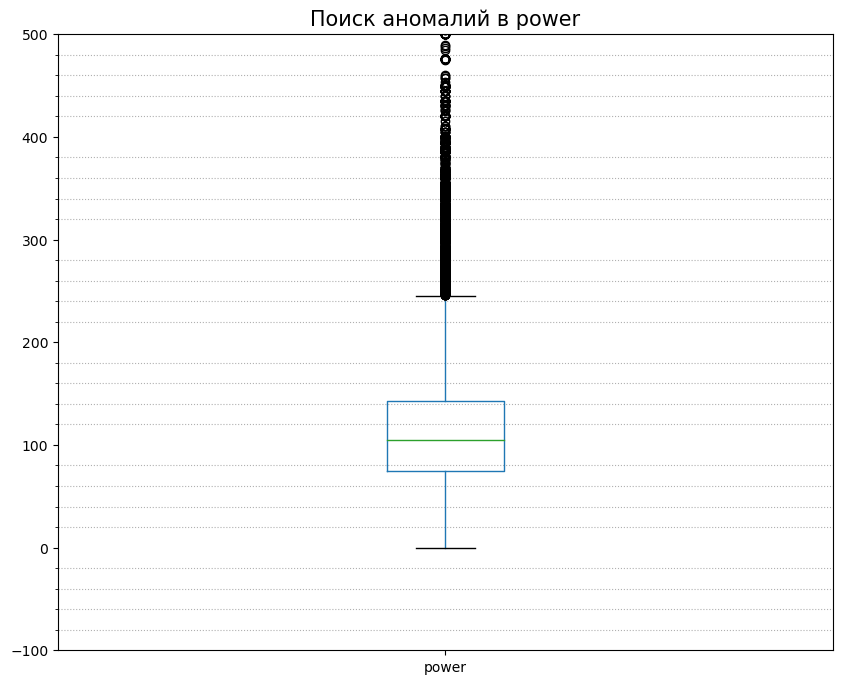

In [33]:
plt.figure(figsize=(10, 8))
data.boxplot(column='power')
plt.minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.title('Поиск аномалий в power', fontsize=15)
plt.ylim(-100, 500)
plt.show()

Отфильтруем данные, взяв в датасет только значения расположенные в границах усов, тем самым отсекая аномальные значения, ошибки ввода и артефакты.

In [34]:
data['registration_month'].unique()

array([ 0,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  5,  9], dtype=int64)

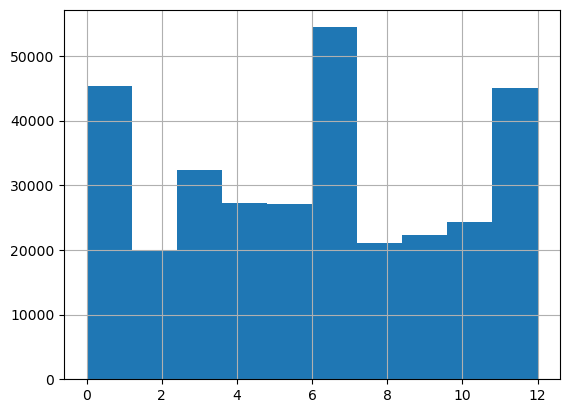

In [35]:
data['registration_month'].hist()
plt.show()

In [36]:
data_filtered = data.query('(0 < power < 260) & (kilometer > 90000) & (0 < price < 16000) & (1985 < registration_year < 2016) & (0 < registration_month)')

In [37]:
data['date_crawled']

0         2016-03-24 11:52:17
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
5         2016-04-04 17:36:23
                 ...         
354363    2016-03-27 20:36:20
354364    2016-03-21 09:50:58
354366    2016-03-05 19:56:21
354367    2016-03-19 18:57:12
354368    2016-03-20 19:41:08
Name: date_crawled, Length: 318962, dtype: object

In [38]:
data['registration_year']

0         1993
2         2004
3         2001
4         2008
5         1995
          ... 
354363    2000
354364    2005
354366    2000
354367    1996
354368    2002
Name: registration_year, Length: 318962, dtype: int64

Удалим неинформативные столбцы.

In [39]:
data_filtered = data_filtered.drop(['date_crawled', 'date_created', 'postal_code', 'number_of_pictures', 'last_seen'], axis=1)

In [40]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201511 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               201511 non-null  int64 
 1   vehicle_type        201511 non-null  object
 2   registration_year   201511 non-null  int64 
 3   gear_box            201511 non-null  object
 4   power               201511 non-null  int64 
 5   model               201511 non-null  object
 6   kilometer           201511 non-null  int64 
 7   registration_month  201511 non-null  int64 
 8   fuel_type           201511 non-null  object
 9   brand               201511 non-null  object
 10  repaired            201511 non-null  object
dtypes: int64(5), object(6)
memory usage: 18.4+ MB


In [41]:
data_filtered.head()

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
10,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no


In [42]:
df = data_filtered

Проверим на явные дубликаты и избавимся от них

In [43]:
print(df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

16964


Построим матрицу корреляции для числовых признаков

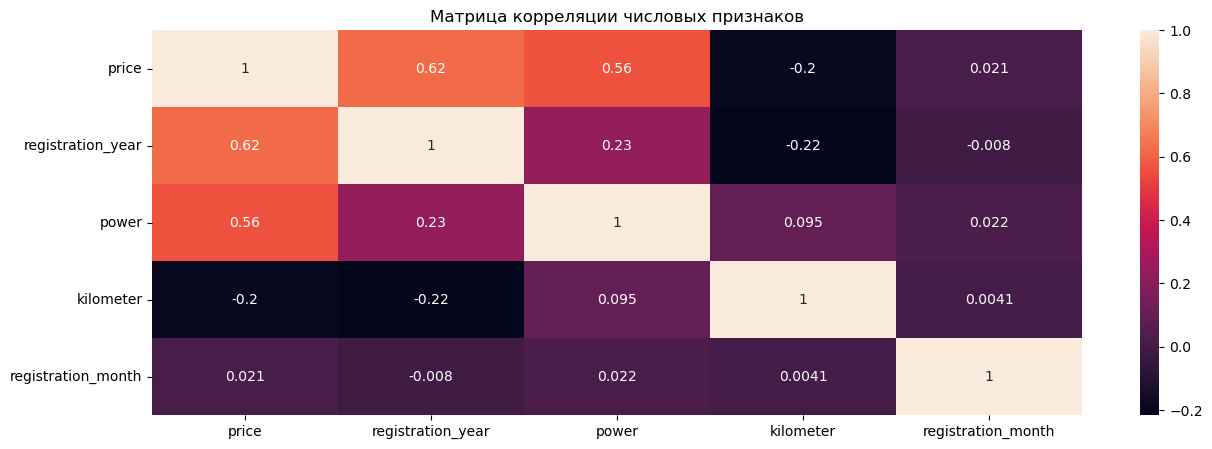

In [44]:
plt.figure(figsize=(15, 5))
plt.title('Матрица корреляции числовых признаков')

sb.heatmap(df.corr(), annot = True)

plt.show()

Выраженная связь присутствует между целевым признаком *price* и обучающими *registration_year* и *power*

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184547 entries, 0 to 184546
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               184547 non-null  int64 
 1   vehicle_type        184547 non-null  object
 2   registration_year   184547 non-null  int64 
 3   gear_box            184547 non-null  object
 4   power               184547 non-null  int64 
 5   model               184547 non-null  object
 6   kilometer           184547 non-null  int64 
 7   registration_month  184547 non-null  int64 
 8   fuel_type           184547 non-null  object
 9   brand               184547 non-null  object
 10  repaired            184547 non-null  object
dtypes: int64(5), object(6)
memory usage: 15.5+ MB


### Вывод

На этапе предобработки данных все столбцы были переименованы. 

Были выявлены и заполнены пропуски в категориальных признаках на значения-заглушки.

Данные были очищены от аномалий, артефактов и ошибок пользовательского ввода.

Были удалены явные дубликаты в данных.

Изучена корреляция числовых признаков.

### Подготовка признаков

Изучим количество уникальных значений в категориальных признаках "модель" и "бренд".

In [46]:
len(np.unique(df['model']))

244

In [47]:
len(np.unique(df['brand']))

39

In [48]:
df

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
2,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
3,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no
4,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no
...,...,...,...,...,...,...,...,...,...,...,...
184542,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no
184543,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes
184544,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
184545,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Для работы с алгоритмами CatBoost и LightGBM преобразуем категориальные признаки в тип *category*


In [49]:
df[['vehicle_type', 'gear_box', 'fuel_type', 'repaired', 'brand', 'model']]= df[['vehicle_type', 'gear_box', 'fuel_type', 
                                                                        'repaired', 'brand', 'model']].astype('category')


Разобьем данные на выборки

In [50]:
X = df.drop(['price'], axis=1)
y = df['price']

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=STATE)

print('X_train:', X_train.shape)
print('X_valid:', X_valid.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_valid:', y_valid.shape)
print('y_test:', y_test.shape)

X_train: (110728, 10)
X_valid: (36909, 10)
X_test: (36910, 10)
y_train: (110728,)
y_valid: (36909,)
y_test: (36910,)


In [52]:
cat_features = ['vehicle_type', 'gear_box', 'fuel_type', 'repaired', 'brand', 'model']

Проведем кодирование признаков с помощью OrdinalEncoder

In [53]:
X_train_encoded = X_train.copy()
X_valid_encoded = X_valid.copy()
X_test_encoded = X_test.copy()


enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train_encoded[cat_features] = enc.fit_transform(X_train_encoded[cat_features])
X_valid_encoded[cat_features] = enc.transform(X_valid_encoded[cat_features])
X_test_encoded[cat_features] = enc.transform(X_test_encoded[cat_features])

## Обучение моделей

### CatBoostRegressor

In [54]:
%%time


model = CatBoostRegressor(loss_function='RMSE', iterations=100, verbose=20, thread_count=-1, random_seed=12345)

model.fit(X_train_encoded, y_train)

pred_valid = model.predict(X_valid_encoded)
    
print(f'RMSE: {mean_squared_error(y_valid, pred_valid, squared=False)}')



Learning rate set to 0.5
0:	learn: 2440.7925377	total: 174ms	remaining: 17.2s
20:	learn: 1396.5944663	total: 389ms	remaining: 1.46s
40:	learn: 1334.9823461	total: 617ms	remaining: 888ms
60:	learn: 1304.1016057	total: 855ms	remaining: 547ms
80:	learn: 1284.2127178	total: 1.12s	remaining: 262ms
99:	learn: 1267.5581022	total: 1.34s	remaining: 0us
RMSE: 1312.270872115976
Wall time: 1.49 s


### LinearRegression

In [55]:
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.head()

,price,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2200,2004,109,150000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2000,2004,105,150000,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
y_ohe = data_ohe['price']
X_ohe = data_ohe.drop('price', axis=1)
X_train_ohe, X_valid_ohe, y_train_ohe, y_valid_ohe = train_test_split(X_ohe, y_ohe, test_size=0.4, random_state=STATE)
X_valid_ohe, X_test_ohe, y_valid_ohe, y_test_ohe = train_test_split(X_valid_ohe, y_valid_ohe, test_size=0.5, random_state=STATE)

In [57]:
numeric = ['price','registration_year','power','kilometer','registration_month']
numeric.remove('price')

Для обучения линейной регрессии проведем масштабирование данных.

In [58]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(X_train_ohe[numeric])
X_train_ohe[numeric] = scaler.transform(X_train_ohe[numeric])
X_valid_ohe[numeric] = scaler.transform(X_valid_ohe[numeric])
X_test_ohe[numeric] = scaler.transform(X_test_ohe[numeric])

In [59]:
pd.DataFrame(X_train_ohe, columns = X_ohe.columns).head()

,registration_year,power,kilometer,registration_month,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
20540,0.012733,-0.393282,0.447602,0.183865,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1379,-1.034584,0.134167,0.447602,-0.710080,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
160681,0.431660,-0.019673,-1.416194,0.779828,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
154631,0.641123,-1.294341,-1.416194,0.481846,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
133863,0.641123,-0.854800,0.447602,-0.710080,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
%%time

model = LinearRegression().fit(X_train_ohe, y_train_ohe)

pred_valid = model.predict(X_valid_ohe)

print(f'RMSE of Linear Regression: {mean_squared_error(y_valid_ohe, pred_valid, squared=False)}')

RMSE of Linear Regression: 1820.4105761976386
Wall time: 2.97 s


### LGBMRegressor

In [61]:
%%time


model = lgb.LGBMRegressor()
model.fit(X_train_encoded, y_train, eval_metric='rmse')
pred_valid = model.predict(X_valid_encoded)

print(f'RMSE of LightGBM: {mean_squared_error(y_valid, pred_valid, squared=False)}')

RMSE of LightGBM: 1327.0116157972118
Wall time: 620 ms


### DecisionTreeRegressor

In [62]:
%%time

model = DecisionTreeRegressor(max_depth=10).fit(X_train_encoded, y_train)
pred_valid = model.predict(X_valid_encoded)

print(f'RMSE of Desicion Tree: {mean_squared_error(y_valid, pred_valid, squared=False)}')

RMSE of Desicion Tree: 1531.8829422648319
Wall time: 279 ms


### Подбор параметров для моделей градиентного бустинга

### CatBoostRegressor

In [63]:
%%time


model = CatBoostRegressor(loss_function='RMSE',
                          verbose=50,
                          thread_count=-1,
                          random_seed=12345)
grid = {'learning_rate': [0.1, 0.5],
        'depth': [10, 12],
        'l2_leaf_reg': [3, 7],
        'iterations' : [50, 200]}
grid_search_result = model.grid_search(grid, 
                                       X=X_train_encoded, 
                                       y=y_train,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4742.2806213	test: 4734.3548724	best: 4734.3548724 (0)	total: 22.6ms	remaining: 1.11s
49:	learn: 1366.5655163	test: 1374.4415076	best: 1374.4415076 (49)	total: 1.24s	remaining: 0us

bestTest = 1374.441508
bestIteration = 49

0:	loss: 1374.4415076	best: 1374.4415076 (0)	total: 1.31s	remaining: 19.7s
0:	learn: 3078.3354409	test: 3077.5019527	best: 3077.5019527 (0)	total: 25.4ms	remaining: 1.25s
49:	learn: 1205.7044906	test: 1288.7654736	best: 1288.7654736 (49)	total: 1.23s	remaining: 0us

bestTest = 1288.765474
bestIteration = 49

1:	loss: 1288.7654736	best: 1288.7654736 (1)	total: 2.55s	remaining: 17.9s
0:	learn: 4748.1019193	test: 4740.3736367	best: 4740.3736367 (0)	total: 23.6ms	remaining: 1.16s
49:	learn: 1376.6011614	test: 1380.2540088	best: 1380.2540088 (49)	total: 1.29s	remaining: 0us

bestTest = 1380.254009
bestIteration = 49

2:	loss: 1380.2540088	best: 1288.7654736 (1)	total: 3.86s	remaining: 16.7s
0:	learn: 3104.3537092	test: 3104.6507570	best: 3104.6507570 (0)	total

In [64]:
grid_search_result['params']

{'depth': 12, 'l2_leaf_reg': 3, 'iterations': 200, 'learning_rate': 0.1}

Теперь обучим модель с лучшими параметрами на тренировочных данных.

In [65]:
%%time
 
model = CatBoostRegressor(loss_function='RMSE',
                          **grid_search_result['params'],
                          verbose=20,
                          thread_count=-1,
                          random_seed=12345)
model.fit(X_train_encoded, y_train)
pred_valid = model.predict(X_valid_encoded)

print(f'RMSE: {mean_squared_error(y_valid, pred_valid, squared=False)}')

0:	learn: 3230.3490883	total: 74.6ms	remaining: 14.8s
20:	learn: 1499.7740341	total: 1.49s	remaining: 12.7s
40:	learn: 1338.0610753	total: 2.76s	remaining: 10.7s
60:	learn: 1292.8915373	total: 4.07s	remaining: 9.27s
80:	learn: 1262.2840467	total: 5.31s	remaining: 7.81s
100:	learn: 1242.8007889	total: 6.56s	remaining: 6.43s
120:	learn: 1221.7988374	total: 7.83s	remaining: 5.11s
140:	learn: 1205.2501351	total: 9.1s	remaining: 3.81s
160:	learn: 1190.2622845	total: 10.4s	remaining: 2.51s
180:	learn: 1178.1879538	total: 11.6s	remaining: 1.22s
199:	learn: 1166.4493634	total: 13s	remaining: 0us
RMSE: 1279.3666378137077
Wall time: 13.3 s


### LGBMRegressor

In [66]:
%%time

params = {
    'num_leaves': [50, 70, 100],
    'learning_rate': [0.1, 0.05],
    'max_depth': [10, 12],
}


lgb_model = lgb.LGBMRegressor(n_estimators=1000,
                          random_state=STATE,
                          n_jobs=-1)
grid = GridSearchCV(estimator=lgb_model, param_grid=params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train_encoded, y_train)

print(grid.best_estimator_)
print(grid.best_params_)

LGBMRegressor(learning_rate=0.05, max_depth=12, n_estimators=1000,
              num_leaves=70,
              random_state=RandomState(MT19937) at 0x22FAFC67940)
{'learning_rate': 0.05, 'max_depth': 12, 'num_leaves': 70}
Wall time: 4min 9s


## Анализ моделей

Измерим метрику rmse на моделях градиентного бустинга с лучшими параметрами, а так же на моделях линейной регрессии и решающего дерева.

Так же получим время в секундах с помощью функции time() модуля time, для вычисления времени обучения и предсказания моделей.

In [67]:
rmse = []
predict = []
train = []

**Обучение моделей**

In [68]:
start = time.time()

model = CatBoostRegressor(loss_function='RMSE',
                          **grid_search_result['params'],
                          silent=True,
                          thread_count=-1,
                          random_seed=12345)
model.fit(X_train_encoded, y_train)
end = time.time()
train.append(end - start)

In [69]:
start = time.time()

lgb_model = lgb.LGBMRegressor(**grid.best_params_,
                            random_state=STATE,
                            n_jobs=-1)
lgb_model.fit(X_train_encoded, y_train)

end = time.time()

train.append(end - start)

In [70]:
start = time.time()

model_lr = LinearRegression().fit(X_train_ohe, y_train_ohe)

end = time.time()

train.append(end - start)

In [71]:
start = time.time()

model_dt = DecisionTreeRegressor(max_depth=10).fit(X_train_encoded, y_train)

end = time.time()

train.append(end - start)

**Предсказания моделей**

In [72]:
start = time.time()

pred_catboost = model.predict(X_test_encoded)

end = time.time()

predict.append(end - start)

In [73]:
start = time.time()

pred_lgb = lgb_model.predict(X_test_encoded)

end = time.time()

predict.append(end - start)

In [74]:
start = time.time()

pred_lg = model_lr.predict(X_test_ohe)

end = time.time()

predict.append(end - start)

In [75]:
start = time.time()

pred_dt = model_dt.predict(X_test_encoded)

end = time.time()

predict.append(end - start)

**Расчет метрик rmse**

In [76]:
mean_squared_error(y_test_ohe, pred_lg, squared=False)

1810.6442588210184

In [77]:
rmse.append(mean_squared_error(y_test, pred_catboost, squared=False))
rmse.append(mean_squared_error(y_test, pred_lgb, squared=False))
rmse.append(mean_squared_error(y_test_ohe, pred_lg, squared=False))
rmse.append(mean_squared_error(y_test, pred_dt, squared=False))

In [78]:
raiting = pd.DataFrame([train, predict, rmse],
             index=['train_time', 'predict_time', 'rmse'],
             columns=['CatBoost', 'LightGBM', 'LinearRegression', 'DecisionTreeRegressor'])

In [79]:
display(raiting)

,CatBoost,LightGBM,LinearRegression,DecisionTreeRegressor
train_time,13.214730,0.665875,2.438337,0.262453
predict_time,0.045431,0.073890,0.079322,0.010108
rmse,1285.159697,1337.216743,1810.644259,1545.673887


### Вывод

В ходе выполнения проектной работы были проведены: 

- загрузка и предобработка данных, включающие в себя заполнение пропусков, поиск и устранение дубликатов, выявление и отбраковка аномалий. 
- Подготовка признаков к обучению, разделение данных на обучающую, валидационную и тестовую выборки.

Для решения поставленной задачи были рассмотрены следующие модели: 
- CatBoost, 
- LightGBM, 
- LinearRegression
- DecisionTreeRegressor

Все модели были обучены на тренировочных данных с проверкой метрики rmse на валидационной выборке и протестированы с фиксацией времени, затраченного на обучение и предсказание на тестовой выборке.

Одним из условий выполнения проектной работы была задача по достижению метрики RMSE 2500 и менее.
- Все модели отвечают заявленному требованию. 

Так же мы должны учитывать важность для заказчика времени, которое затрачивает модель на обучение и предсказание. 
В соответствии с результатом исследования:
- самой быстрой моделью является LightGBM, но по метрике RMSE она уступает модели CatBoost.

Модель с наименьшим значением метрики RMSE:
- CatBoost, но она требует больше всех прочих моделей времени на обучение.
Таким образом рекомендованная модель:
- LightGBM, с учетом показателя метрики RMSE 
- DecisionTreeRegressor, в случае если скорость обучения более предпочтительна, чем качество предсказания.